## Facebook Prophet model

https://facebook.github.io/prophet/

In [ ]:
#!pip install Prophet

## Merging Weather and Load data together to start
- hourly data merged first then daily merged (using daily value for each hour)

In [7]:
import pandas as pd

# Load the datasets
load_data = pd.read_csv("load_files/merged_load_data_verticalFormat_cleaned.csv", usecols=["Dt", "Hour", "BasicLoad"])
weather_hourly = pd.read_csv("weather_files/merged_weather_data_verticalFormat_cleaned.csv", usecols=["Dt", "Hour", "Temp", "Humidity", "THI", "Windchill"])
weather_daily = pd.read_csv("weather_files/merged_weather_data_rain-daily.csv", usecols=["Dt", "Rainfall", "AvgDB"])

# Merge the hourly weather data with load data on 'Dt' and 'Hour'
merged_hourly = pd.merge(load_data, weather_hourly, on=["Dt", "Hour"], how="inner")

# Merge the daily weather data by filling in the daily values for each hour
merged_data = pd.merge(merged_hourly, weather_daily, on="Dt", how="left")

# Fill each hourly row with the corresponding daily values
merged_data["Rainfall"] = merged_data["Rainfall"].fillna(method='ffill')
merged_data["AvgDB"] = merged_data["AvgDB"].fillna(method='ffill')

# Convert 'Dt' to datetime
merged_data["Dt"] = pd.to_datetime(merged_data["Dt"])

# Combine 'Dt' and 'Hour' into a single datetime column 'ds' for Prophet
merged_data["ds"] = merged_data["Dt"] + pd.to_timedelta(merged_data["Hour"] - 1, unit="h")


# Save the merged data
merged_data.to_csv("prophet_files/merged_load_weather_data.csv", index=False)

print("Done - Merged data with correct datetime format saved.")



Done - Merged data with correct datetime format saved.


## Basic Prophet model - only time and y(load) used

11:29:26 - cmdstanpy - INFO - Chain [1] start processing
11:31:10 - cmdstanpy - INFO - Chain [1] done processing


All forecasts and labeled seasonality plots completed and saved.


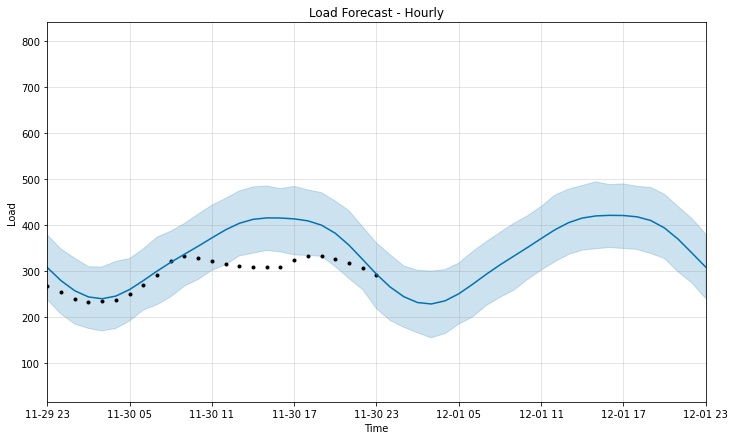

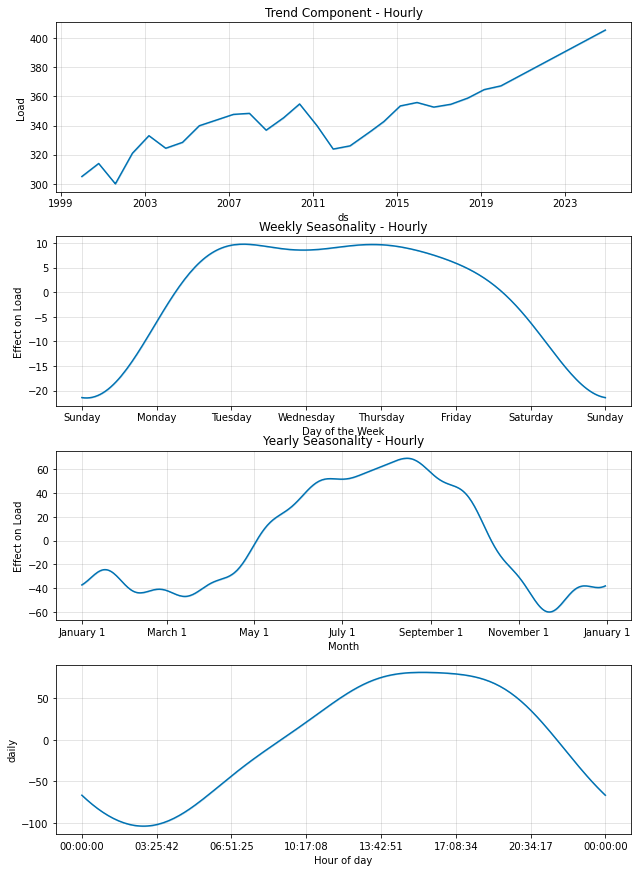

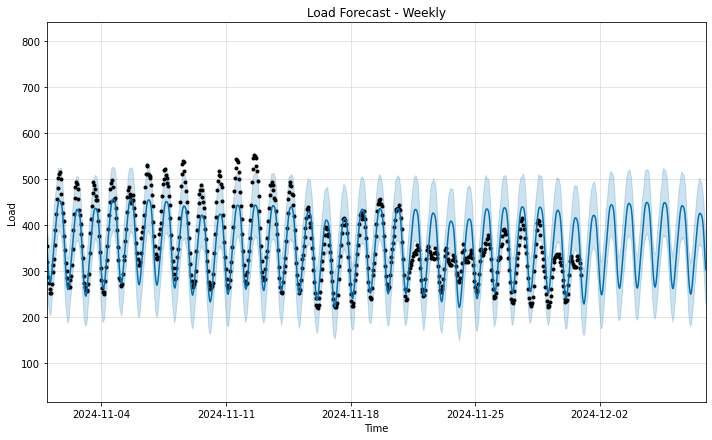

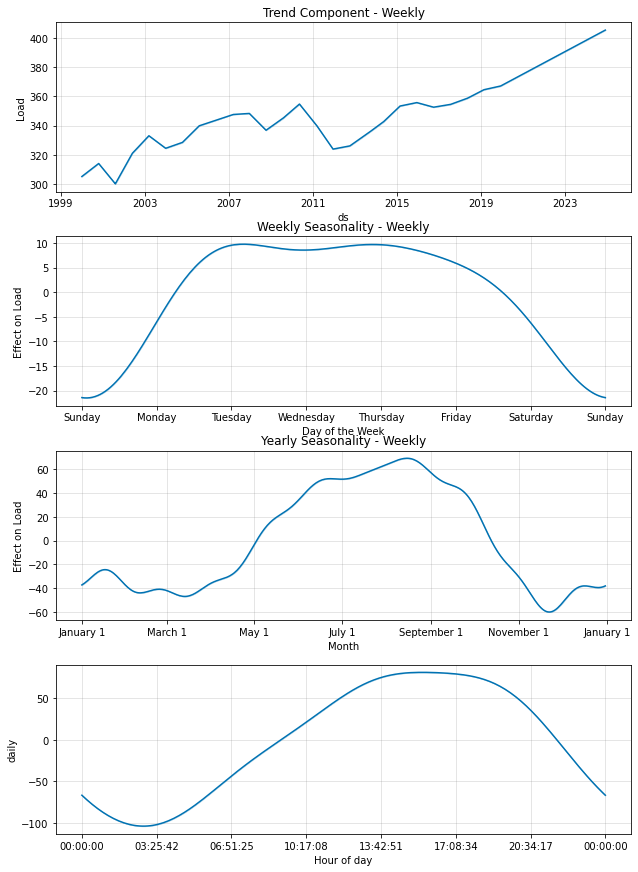

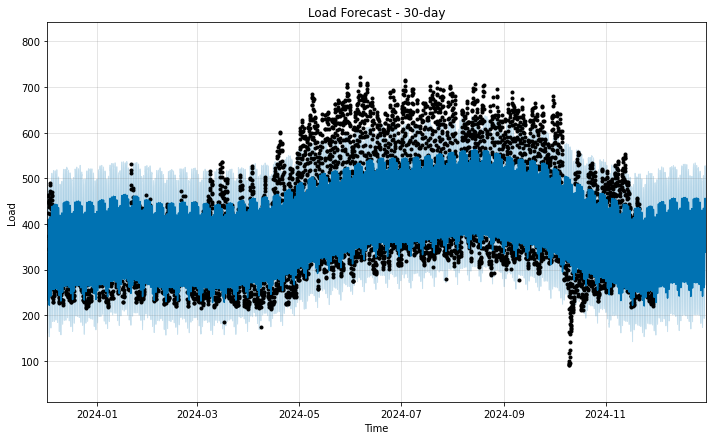

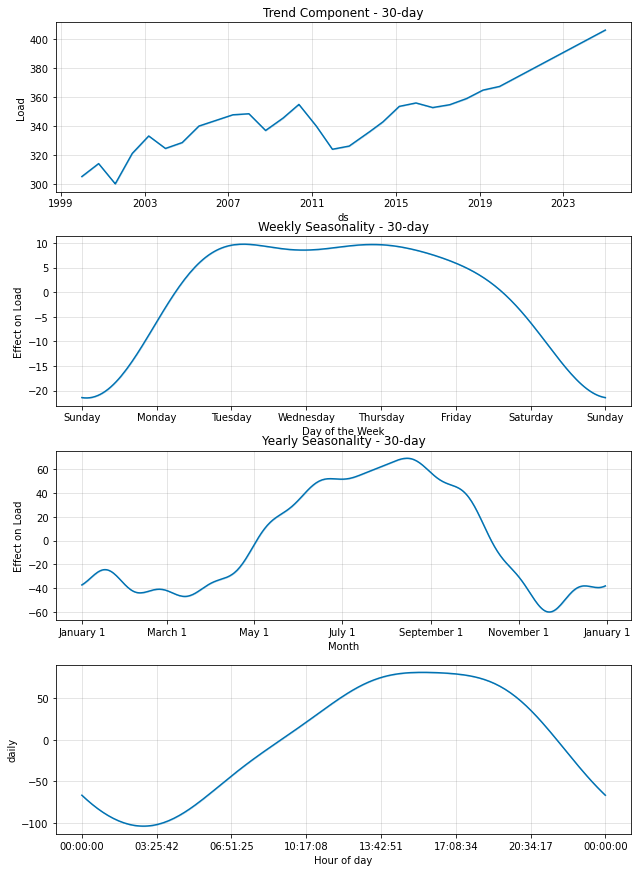

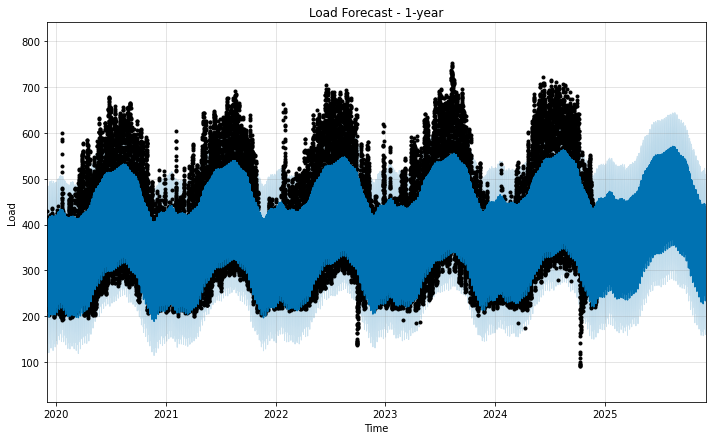

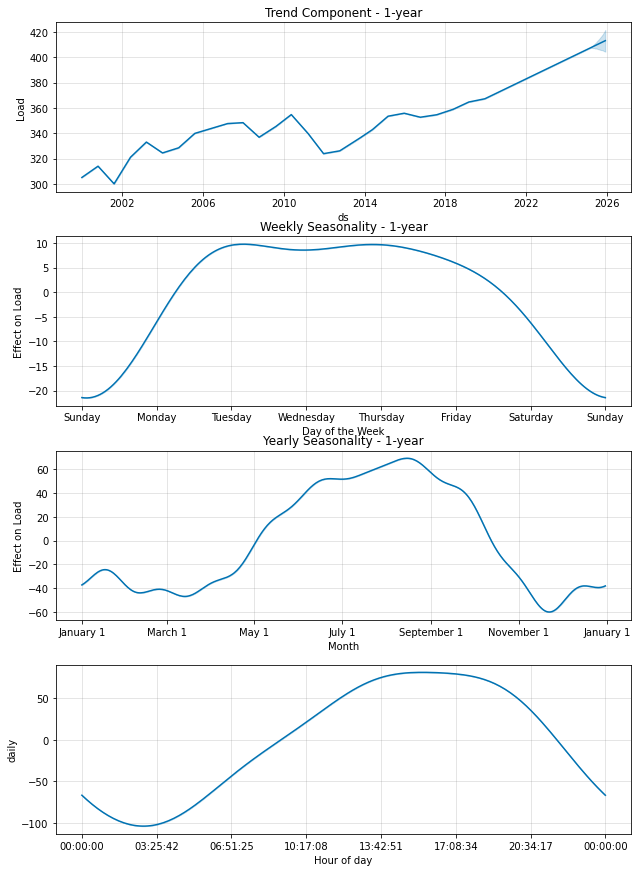

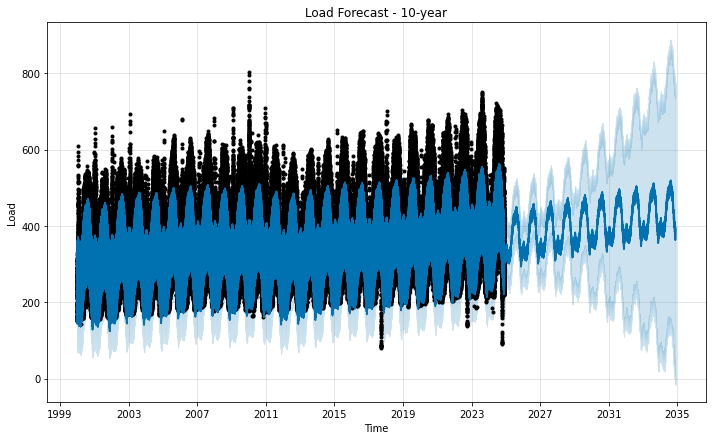

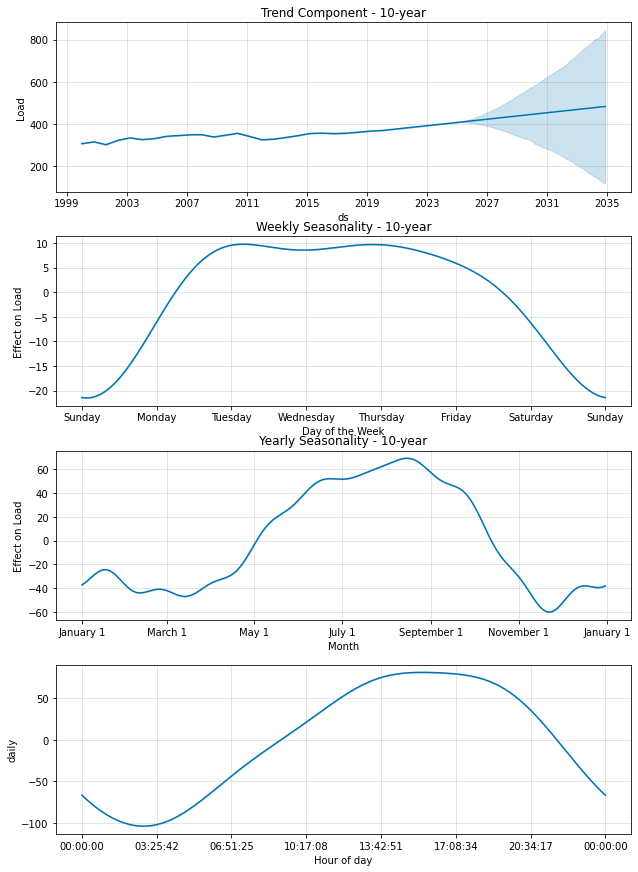

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import os

# Create output directory if not exists
output_dir = "prophet_files"
os.makedirs(output_dir, exist_ok=True)

# Load the merged dataset
merged_data = pd.read_csv(f"{output_dir}/merged_load_weather_data.csv")

# Convert 'ds' column to datetime (ensures proper format)
merged_data["ds"] = pd.to_datetime(merged_data["ds"])

# Prepare data for Prophet
prophet_df = merged_data[["ds", "BasicLoad"]].rename(columns={"BasicLoad": "y"})

# Initialize and fit the Prophet model with weekly and yearly seasonality
model = Prophet(weekly_seasonality=True, yearly_seasonality=True)
model.fit(prophet_df)

# Get the last date in the historical dataset
last_date = prophet_df["ds"].max()

# Define forecast periods with historical context
forecasts = {
    "hourly": {"periods": 24, "freq": "H", "history": pd.Timedelta(days=1)},  # Last day + 24-hour forecast
    "weekly": {"periods": 24*7, "freq": "H", "history": pd.Timedelta(days=30)},  # Last 30 days + 7-day forecast
    "30-day": {"periods": 24*30, "freq": "H", "history": pd.Timedelta(days=365)},  # Last year + 30-day forecast
    "1-year": {"periods": 24*365, "freq": "H", "history": pd.Timedelta(days=5*365)},  # Last 5 years + 1-year forecast
    "10-year": {"periods": 365*10, "freq": "D", "history": None}  # No zoom adjustment for 10 years
}

# Generate and save forecasts with improved labeling and historical context
for name, params in forecasts.items():
    future_df = model.make_future_dataframe(periods=params["periods"], freq=params["freq"])
    forecast = model.predict(future_df)
    
    # Save forecast data
    forecast.to_csv(f"{output_dir}/no_regressors_load_forecast_{name}.csv", index=False)

    # Create and customize forecast plot
    fig1 = model.plot(forecast)
    ax1 = fig1.gca()
    ax1.set_title(f"Load Forecast - {name.capitalize()}")
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Load")

    # Adjust x-axis limits to include historical context
    if params["history"] is not None:
        ax1.set_xlim(last_date - params["history"], future_df["ds"].max())

    fig1.savefig(f"{output_dir}/no_regressors_load_forecast_{name}.png")

    # Create and customize trend & seasonality plot
    fig2 = model.plot_components(forecast)
    axes = fig2.get_axes()

    # Customizing each subplot (Trend, Weekly, Yearly)
    axes[0].set_title(f"Trend Component - {name.capitalize()}")
    axes[0].set_ylabel("Load")

    axes[1].set_title(f"Weekly Seasonality - {name.capitalize()}")
    axes[1].set_xlabel("Day of the Week")
    axes[1].set_ylabel("Effect on Load")

    axes[2].set_title(f"Yearly Seasonality - {name.capitalize()}")
    axes[2].set_xlabel("Month")
    axes[2].set_ylabel("Effect on Load")

    fig2.savefig(f"{output_dir}/no_regressors_load_trend_seasonality_{name}.png")

print("All forecasts and labeled seasonality plots completed and saved.")



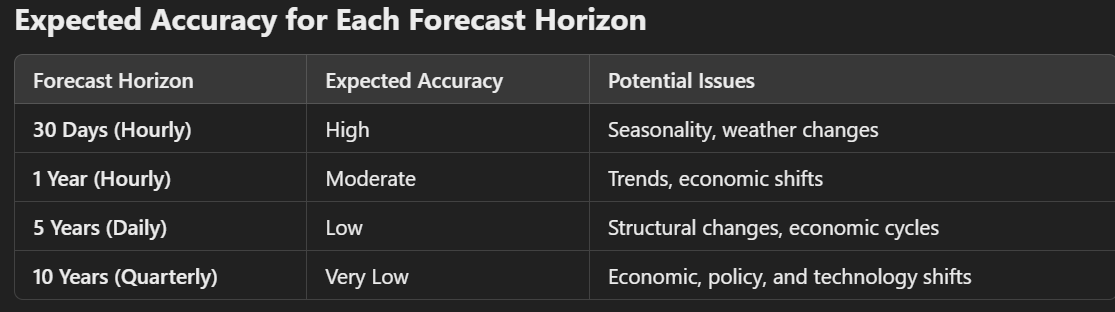

option 1 - use values for moodey for every hour/day in the quarter
option 2 - interpolate value as the 'center' and create a way to scale it to the next 'center' from the next quarter

moodey's: get the actual data and compare how they work